# 1. Import thư viện

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kiểm tra xem có GPU không
print("Phiên bản TensorFlow:", tf.__version__)
print("Thiết bị đang sử dụng:", tf.test.gpu_device_name() if tf.test.gpu_device_name() else "CPU")

Phiên bản TensorFlow: 2.19.0
Thiết bị đang sử dụng: /device:GPU:0


# 2. Tải dữ liệu từ Kaggle về

In [ ]:
# Cài đặt thư viện kaggle
!pip install -q kaggle

# Thêm bước tạo thư mục .kaggle nếu chưa có
!mkdir -p ~/.kaggle

In [ ]:
# Upload file kaggle.json vừa tải về lên đây
from google.colab import files
uploaded = files.upload()

# Kiểm tra và cấu hình đúng file kaggle.json
for filename in uploaded.keys():
    if 'kaggle' in filename:
        !cp "{filename}" ~/.kaggle/kaggle.json
        !chmod 600 ~/.kaggle/kaggle.json
        print(f"Đã cấu hình thành công file: {filename}")

# Tải bộ dữ liệu
!kaggle datasets download -d samithsachidanandan/human-face-emotions

# Giải nén dữ liệu
!unzip -q human-face-emotions.zip -d Data/

Saving kaggle (1).json to kaggle (1).json
Đã cấu hình thành công file: kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions
License(s): apache-2.0
 99% 695M/701M [00:07<00:00, 162MB/s]
100% 701M/701M [00:07<00:00, 102MB/s]


# 3. EDA

In [ ]:
import os

# Kiểm tra xem cấu trúc thực tế là gì
!ls -R data | head -n 20

base_path = 'Data/Data/'

emotion_counts = {}

# Kiểm tra lại
if os.path.exists(base_path):
    for emotion in os.listdir(base_path):
        path = os.path.join(base_path, emotion)
        if os.path.isdir(path):
            emotion_counts[emotion] = len(os.listdir(path))
    print("Cấu trúc mới tìm thấy:", emotion_counts)
else:
    print("Đường dẫn base_path không đúng, hãy kiểm tra lại bằng lệnh !ls data")

ls: cannot access 'data': No such file or directory
Cấu trúc mới tìm thấy: {'Happy': 18439, 'Fear': 9732, 'Suprise': 8227, 'Angry': 10148, 'Sad': 12553}


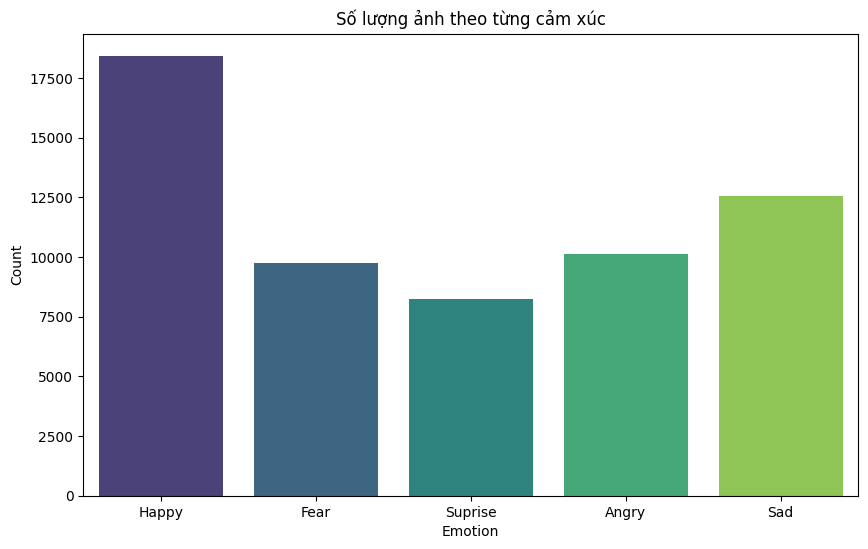

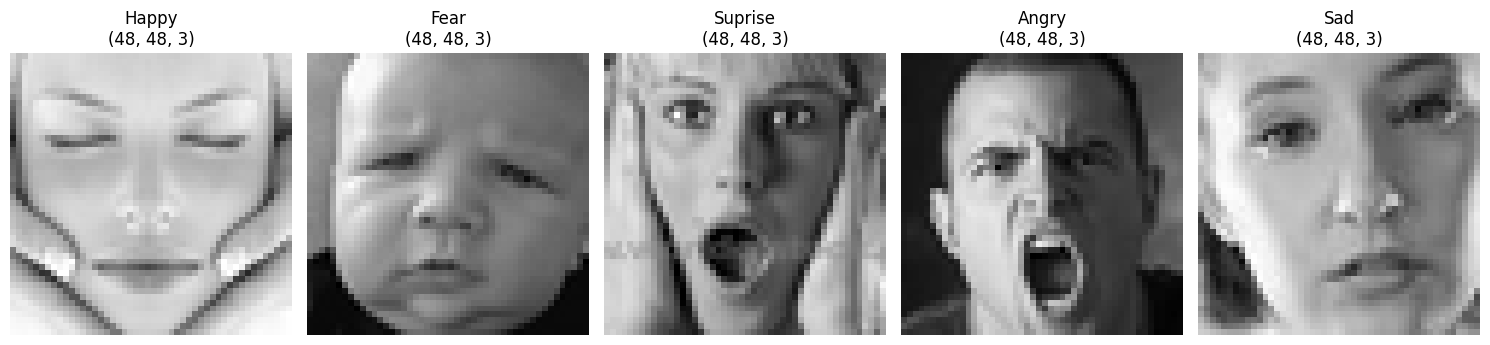

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ lại biểu đồ
df = pd.DataFrame(list(emotion_counts.items()), columns=['Emotion', 'Count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Emotion', y='Count', data=df, hue='Emotion', palette='viridis', legend=False)
plt.title('Số lượng ảnh theo từng cảm xúc')
plt.show()

# Xem ảnh mẫu từ base_path mới
import cv2
import random

plt.figure(figsize=(15, 5))
emotions = list(emotion_counts.keys())

for i, emotion in enumerate(emotions):
    folder_path = os.path.join(base_path, emotion)
    img_names = os.listdir(folder_path)
    if len(img_names) > 0:
        img_name = random.choice(img_names)
        img_path = os.path.join(folder_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{emotion}\n{img.shape}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# 4. Chia dữ liệu

In [ ]:
import tensorflow as tf

base_path = 'Data/Data/'

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=256,
    color_mode='grayscale'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=256,
    color_mode='grayscale'
)

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.


# 5. Xây dựng model CNN

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,128,1)),

    tf.keras.layers.Conv2D(32,(3,3),padding="same",kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(32,(3,3),padding="same",kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64,(3,3),padding="same",kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64,(3,3),padding="same",kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128,(3,3),padding="same",kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(128,(3,3),padding="same",kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(5,activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 16, 128)    │             

 Total params: 4,487,653 (17.12 MB)

 Trainable params: 4,485,733 (17.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

# 6. Train model

In [ ]:
initial_learning_rate = 0.001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(base_path, 'best_custom_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4208 - loss: 1.5641

185/185 ━━━━━━━━━━━━━━━━━━━━ 143s 564ms/step - accuracy: 0.4211 - loss: 1.5630 - val_accuracy: 0.4470 - val_loss: 1.3361 - learning_rate: 0.0010
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6005 - loss: 1.0490

185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 444ms/step - accuracy: 0.6005 - loss: 1.0487 - val_accuracy: 0.5848 - val_loss: 1.0547 - learning_rate: 0.0010
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6693 - loss: 0.8414

185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 442ms/step - accuracy: 0.6694 - loss: 0.8411 - val_accuracy: 0.6762 - val_loss: 0.8357 - learning_rate: 0.0010
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7535 - loss: 0.6611

185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 443ms/step - accuracy: 0.7536 - loss: 0.6609 - val_accuracy: 0.7464 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8080 - loss: 0.5255

185/185 ━━━━━━━━━━━━━━━━━━━━ 74s 399ms/step - accuracy: 0.8081 - loss: 0.5253 - val_accuracy: 0.7704 - val_loss: 0.6401 - learning_rate: 0.0010
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8574 - loss: 0.4071

185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - accuracy: 0.8575 - loss: 0.4069 - val_accuracy: 0.7991 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8954 - loss: 0.3064

185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 444ms/step - accuracy: 0.8955 - loss: 0.3063 - val_accuracy: 0.8462 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9187 - loss: 0.2392

185/185 ━━━━━━━━━━━━━━━━━━━━ 84s 447ms/step - accuracy: 0.9188 - loss: 0.2391 - val_accuracy: 0.8525 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9407 - loss: 0.1828

185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 444ms/step - accuracy: 0.9407 - loss: 0.1828 - val_accuracy: 0.8875 - val_loss: 0.3805 - learning_rate: 0.0010
Epoch 10/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 449ms/step - accuracy: 0.9510 - loss: 0.1522 - val_accuracy: 0.8636 - val_loss: 0.4714 - learning_rate: 0.0010
Epoch 11/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 76s 411ms/step - accuracy: 0.9600 - loss: 0.1265 - val_accuracy: 0.8788 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 12/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9651 - loss: 0.1106

185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.9651 - loss: 0.1106 - val_accuracy: 0.9041 - val_loss: 0.3652 - learning_rate: 0.0010
Epoch 13/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 445ms/step - accuracy: 0.9703 - loss: 0.0975 - val_accuracy: 0.8933 - val_loss: 0.4161 - learning_rate: 0.0010
Epoch 14/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9729 - loss: 0.0903

185/185 ━━━━━━━━━━━━━━━━━━━━ 75s 403ms/step - accuracy: 0.9729 - loss: 0.0903 - val_accuracy: 0.9067 - val_loss: 0.3558 - learning_rate: 0.0010
Epoch 15/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9754 - loss: 0.0817

185/185 ━━━━━━━━━━━━━━━━━━━━ 92s 455ms/step - accuracy: 0.9754 - loss: 0.0816 - val_accuracy: 0.9102 - val_loss: 0.3906 - learning_rate: 0.0010
Epoch 16/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9765 - loss: 0.0769

185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.9765 - loss: 0.0769 - val_accuracy: 0.9105 - val_loss: 0.3813 - learning_rate: 0.0010
Epoch 17/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9794 - loss: 0.0713
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
185/185 ━━━━━━━━━━━━━━━━━━━━ 76s 412ms/step - accuracy: 0.9794 - loss: 0.0712 - val_accuracy: 0.8884 - val_loss: 0.4844 - learning_rate: 0.0010
Epoch 18/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9833 - loss: 0.0568

185/185 ━━━━━━━━━━━━━━━━━━━━ 88s 444ms/step - accuracy: 0.9833 - loss: 0.0568 - val_accuracy: 0.9255 - val_loss: 0.3457 - learning_rate: 1.0000e-04
Epoch 19/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9892 - loss: 0.0398

185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 446ms/step - accuracy: 0.9893 - loss: 0.0398 - val_accuracy: 0.9261 - val_loss: 0.3399 - learning_rate: 1.0000e-04
Epoch 20/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9910 - loss: 0.0359

185/185 ━━━━━━━━━━━━━━━━━━━━ 74s 402ms/step - accuracy: 0.9910 - loss: 0.0359 - val_accuracy: 0.9273 - val_loss: 0.3373 - learning_rate: 1.0000e-04
Epoch 21/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 441ms/step - accuracy: 0.9926 - loss: 0.0304 - val_accuracy: 0.9266 - val_loss: 0.3382 - learning_rate: 1.0000e-04
Epoch 22/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 443ms/step - accuracy: 0.9934 - loss: 0.0287 - val_accuracy: 0.9261 - val_loss: 0.3388 - learning_rate: 1.0000e-04
Epoch 23/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9935 - loss: 0.0271
Epoch 23: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 444ms/step - accuracy: 0.9936 - loss: 0.0271 - val_accuracy: 0.9265 - val_loss: 0.3441 - learning_rate: 1.0000e-04
Epoch 24/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.9947 - loss: 0.0226 - val_accuracy: 0.9263 - val_loss: 0.3442 - learning_rate: 1.0000e-05
Epoch 25/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 447ms/step -

# 7. Đánh giá & Dự đoán

7.1. Biểu đồ đường Accuracy & Loss

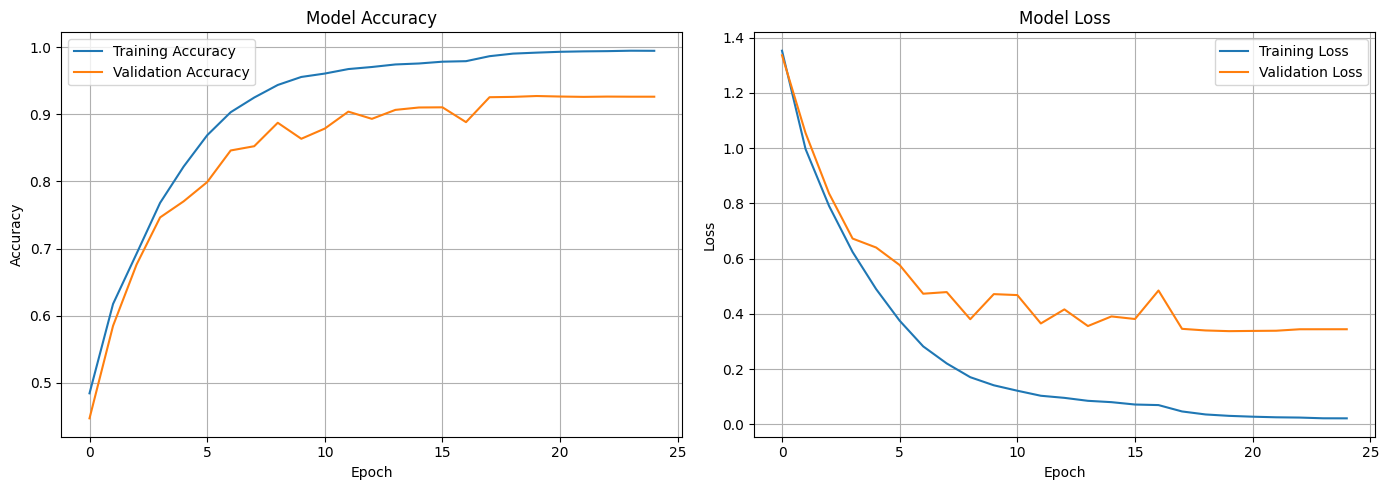

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

7.2. Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = []
y_true = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.class_names))


Classification Report:
              precision    recall  f1-score   support

       Angry       0.91      0.91      0.91      2058
        Fear       0.94      0.84      0.89      1981
       Happy       0.95      0.97      0.96      3648
         Sad       0.89      0.92      0.91      2503
     Suprise       0.94      0.95      0.94      1629

    accuracy                           0.93     11819
   macro avg       0.93      0.92      0.92     11819
weighted avg       0.93      0.93      0.93     11819



7.3. Confusion Matrix

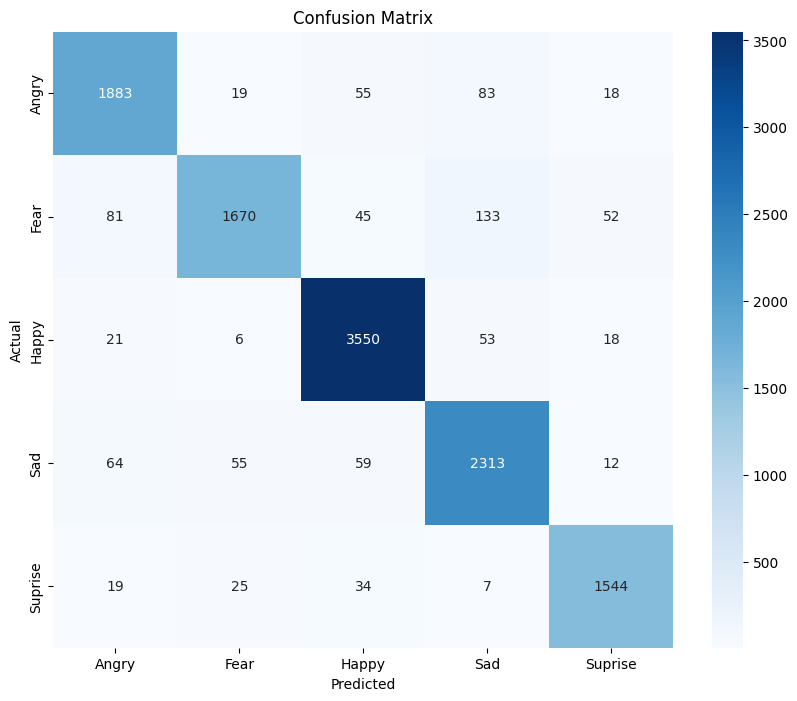

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_ds.class_names, yticklabels=train_ds.class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

7.4. Robustness

In [ ]:
import tensorflow as tf

def evaluate_robustness(model, dataset):
    # Tạo các lớp biến đổi ảnh để test độ bền
    gaussian_noise = tf.keras.layers.GaussianNoise(0.1) # Thêm nhiễu 10%
    brightness_layer = tf.keras.layers.RandomBrightness(factor=0.2) # Thay đổi độ sáng 20%

    # Đánh giá trên tập Validation gốc
    original_acc = model.evaluate(dataset, verbose=0)[1]

    # Đánh giá trên tập bị thêm nhiễu
    noisy_ds = dataset.map(lambda x, y: (gaussian_noise(x, training=True), y))
    noisy_acc = model.evaluate(noisy_ds, verbose=0)[1]

    # Đánh giá trên tập bị thay đổi độ sáng
    bright_ds = dataset.map(lambda x, y: (brightness_layer(x, training=True), y))
    bright_acc = model.evaluate(bright_ds, verbose=0)[1]

    print("KẾT QUẢ ĐỘ BỀN BỈ (ROBUSTNESS):")
    print(f"Accuracy gốc: {original_acc*100:.2f}%")
    print(f"Accuracy khi thêm nhiễu: {noisy_acc*100:.2f}% (Giảm { (original_acc - noisy_acc)*100:.2f}%)")
    print(f"Accuracy khi đổi độ sáng: {bright_acc*100:.2f}% (Giảm { (original_acc - bright_acc)*100:.2f}%)")

# Chạy đánh giá
evaluate_robustness(model, val_ds)

KẾT QUẢ ĐỘ BỀN BỈ (ROBUSTNESS):
Accuracy gốc: 92.73%
Accuracy khi thêm nhiễu: 92.73% (Giảm 0.00%)
Accuracy khi đổi độ sáng: 90.89% (Giảm 1.84%)


7.5. Dự đoán

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from PIL import Image

def show_random_predictions_multi_folders(model, parent_dir, class_names, n=25):
    all_image_data = []

    # 1. Tự động quét tất cả các folder con
    subfolders = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f))]

    for folder in subfolders:
        folder_path = os.path.join(parent_dir, folder)
        images_in_folder = [os.path.join(folder_path, img) for img in os.listdir(folder_path)
                            if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for img_path in images_in_folder:
            all_image_data.append((img_path, folder))

    if not all_image_data:
        print("Không tìm thấy ảnh nào trong các thư mục con!")
        return

    # 2. Chọn ngẫu nhiên n mẫu từ danh sách tổng hợp
    n = min(n, len(all_image_data))
    random_samples = random.sample(all_image_data, n)

    # 3. Cấu hình hiển thị (5 cột)
    n_cols = 5
    n_rows = int(np.ceil(n / n_cols))
    plt.figure(figsize=(18, n_rows * 4))

    for i, (img_path, actual_label) in enumerate(random_samples, 1):
        # 4. Tiền xử lý ảnh
        img = tf.keras.utils.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # 5. Dự đoán
        predictions = model.predict(img_array, verbose=0)
        pred_idx = np.argmax(predictions[0])
        pred_label = class_names[pred_idx]
        confidence = 100 * np.max(predictions[0])

        # 6. Hiển thị
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(img, cmap='gray')
        plt.axis("off")

        # Đổi màu tiêu đề: Xanh nếu đúng, Đỏ nếu sai
        title_color = "green" if pred_label.lower() == actual_label.lower() else "red"
        plt.title(f"Actual: {actual_label}\nPred: {pred_label} ({confidence:.1f}%)",
                  color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()

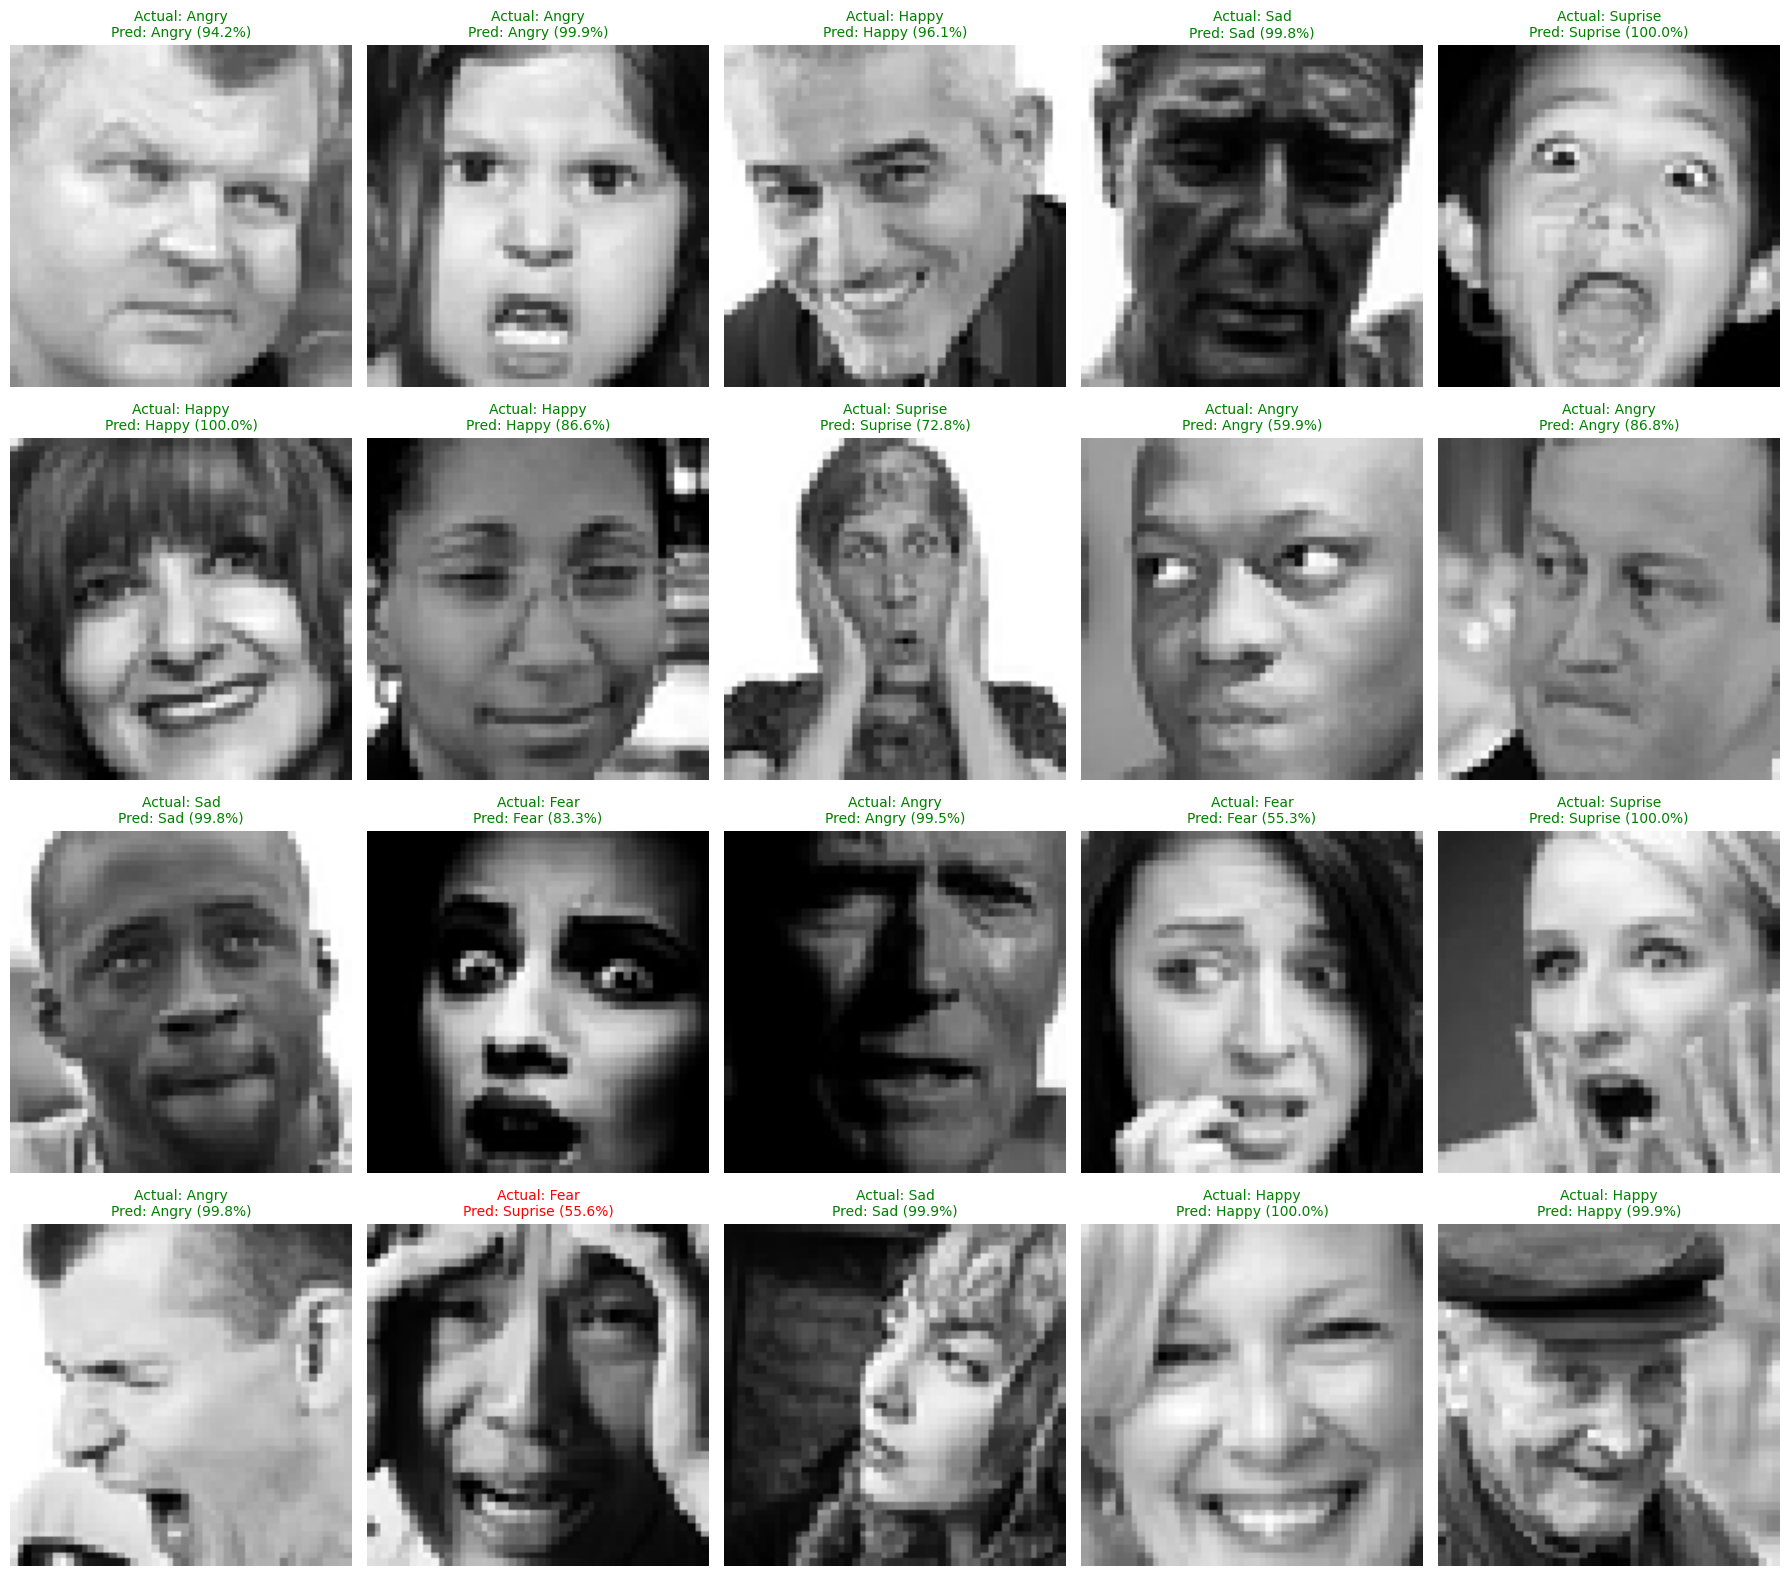

In [ ]:
show_random_predictions_multi_folders(model, base_path, train_ds.class_names, n=20)

7.6. Phân tích dự đoán sai

Tổng số mẫu bị dự đoán sai: 859/11819


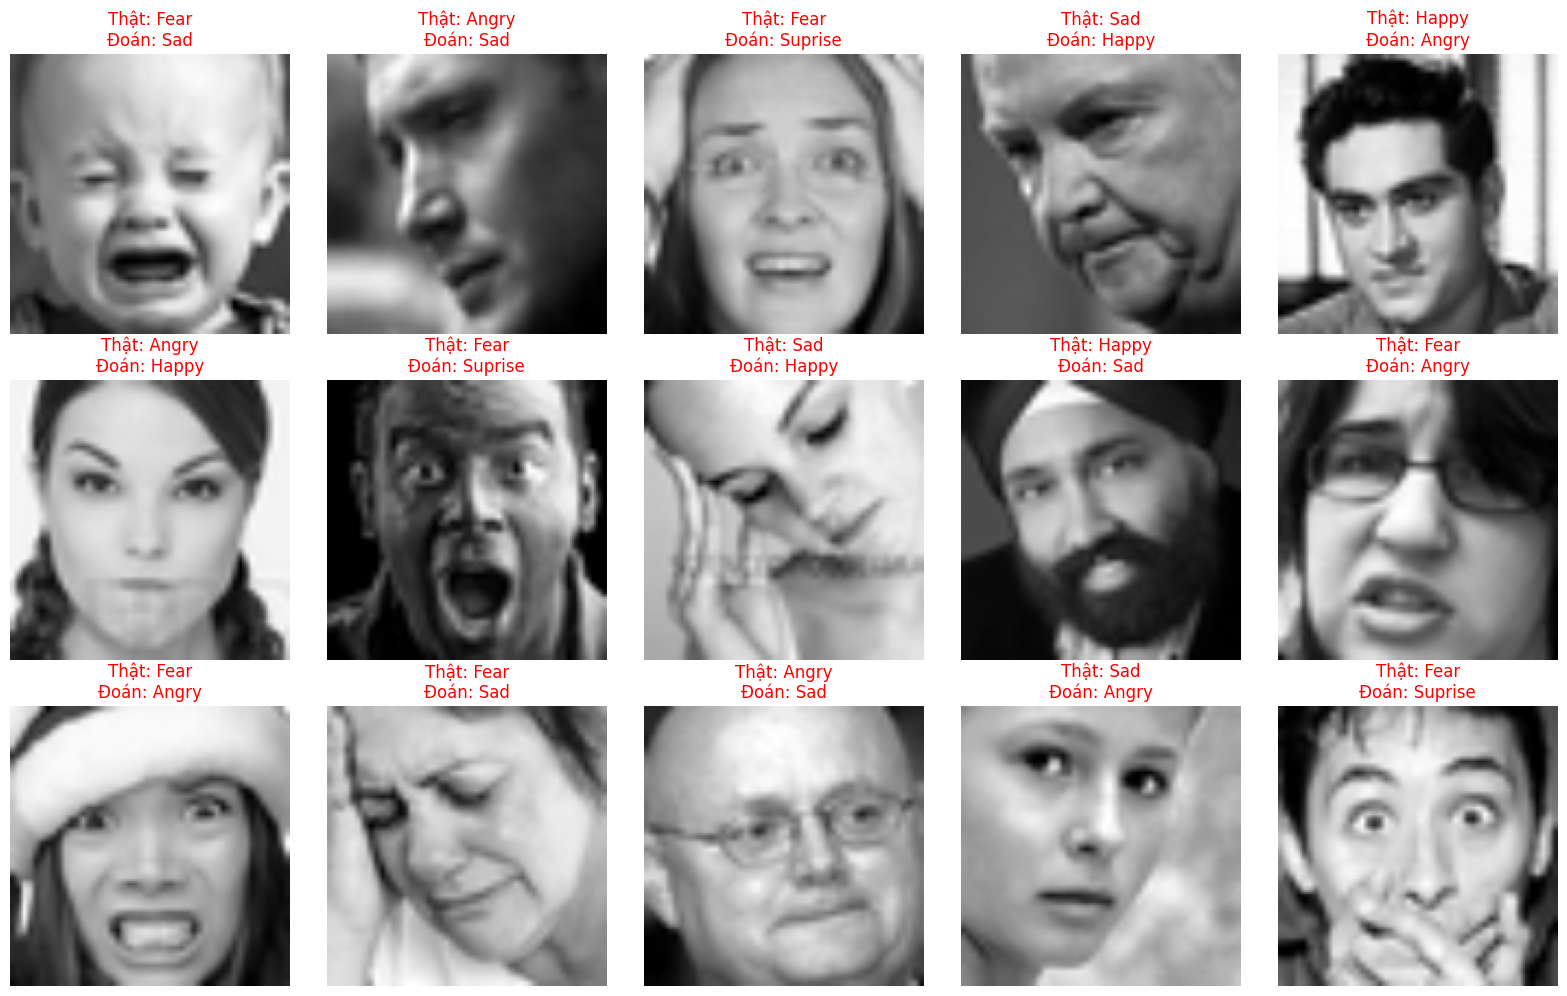

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Thu thập tất cả ảnh, nhãn thật và nhãn dự đoán từ tập validation
all_images = []
all_labels = []
all_preds = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())
    all_preds.append(np.argmax(preds, axis=1))

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# 2. Tìm các vị trí dự đoán sai
misclassified_idx = np.where(all_preds != all_labels)[0]
print(f"Tổng số mẫu bị dự đoán sai: {len(misclassified_idx)}/{len(all_labels)}")

# 3. Hiển thị các mẫu điển hình bị đoán sai
plt.figure(figsize=(16, 10))
for i, idx in enumerate(misclassified_idx[:15]): # Hiển thị 15 mẫu đầu tiên
    plt.subplot(3, 5, i + 1)
    # Vì ảnh ở grayscale (128,128,1), cần reshape để hiển thị
    plt.imshow(all_images[idx].reshape(128, 128), cmap='gray')
    true_name = val_ds.class_names[all_labels[idx]]
    pred_name = val_ds.class_names[all_preds[idx]]
    plt.title(f"Thật: {true_name}\nĐoán: {pred_name}", color='red')
    plt.axis('off')
plt.tight_layout()
plt.show()